# Standard CE 1-1,3
1. I can sketch the "curly" electric field associated with an arbitrary, changing magnetic field.
2. I can estimate the direction of the electric field associated with a region with a uniform, changing magnetic field at an arbitrary location in that region.
# Standard CE 2-1,2
1. I can calculate the voltage around a boundary associated with a uniform, changing magnetic field.
2. I can calculate the magnitude of the electric field associated with a region with a uniform, changing magnetic field at an arbitrary location in that region.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [5]:
class MagneticField:
    """Class to calculate and visualize the dipole magnetic field."""

    def __init__(self, moment_strength, dipole_center, grid_size=(6, 8, 8)):
        """Initialize the magnetic field parameters."""
        self.mu_0 = 4 * np.pi * 1e-7  # Permeability of free space (T·m/A)
        self.m = np.array([moment_strength, 0, 0])  # Magnetic moment along x-axis
        self.dipole_center = np.array(dipole_center)  # Center of the dipole
        self.grid_size = grid_size  # Number of points in (x, y, z)

    def compute_field(self, x, y, z):
        """Computes the dipole magnetic field vector at a given point."""
        r_vec = np.array([x, y, z]) - self.dipole_center  # Shift coordinates by dipole center
        r = np.linalg.norm(r_vec)  # Distance from dipole

        if r == 0:  # Avoid singularity
            return np.array([0, 0, 0])

        r_hat = r_vec / r  # Unit vector
        term1 = 3 * np.dot(self.m, r_hat) * r_hat
        B = (self.mu_0 / (4 * np.pi)) * (term1 - self.m) / (r**3)

        return B  # No artificial scaling applied

    def generate_field_grid(self, bounds=(-3, 3, -2, 2, -2, 2)):
        """Generates a grid of points and computes the magnetic field at each point."""
        x_min, x_max, y_min, y_max, z_min, z_max = bounds
        x = np.linspace(x_min, x_max, self.grid_size[0])
        y = np.linspace(y_min, y_max, self.grid_size[1])
        z = np.linspace(z_min, z_max, self.grid_size[2])
        X, Y, Z = np.meshgrid(x, y, z)

        Bx, By, Bz = np.zeros_like(X), np.zeros_like(Y), np.zeros_like(Z)
        B_magnitude = np.zeros_like(X)  # Store magnitudes for scaling

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                for k in range(X.shape[2]):
                    B = self.compute_field(X[i, j, k], Y[i, j, k], Z[i, j, k])
                    Bx[i, j, k], By[i, j, k], Bz[i, j, k] = B
                    B_magnitude[i, j, k] = np.linalg.norm(B)  # Store magnitude

        return X, Y, Z, Bx, By, Bz, B_magnitude

    def compute_flux(self, loop_radius, num_points=100):
        """Compute the magnetic flux through a vertical circular loop in the YZ-plane."""
        theta = np.linspace(0, 2 * np.pi, num_points)
        y = loop_radius * np.cos(theta)  
        z = loop_radius * np.sin(theta)  
        x = np.zeros_like(theta)  # Loop lies in YZ-plane at x = 0
        
        Bx_values = []
        for i in range(num_points):
            B = self.compute_field(x[i], y[i], z[i])
            Bx_values.append(B[0])  # Extract Bx component
        
        Bx_avg = np.mean(Bx_values)  # Average Bx across the loop
        flux = Bx_avg * (np.pi * loop_radius**2)
        return flux
    
    def plot_field(self, ax, bounds=(-3, 3, -2, 2, -2, 2)):
        """Plots the magnetic field vectors in 3D."""
        X, Y, Z, Bx, By, Bz, B_magnitude = self.generate_field_grid(bounds)
        
        # Normalize the vectors by their magnitudes (to scale properly)
        B_magnitude = np.clip(B_magnitude, 1e-3, np.max(B_magnitude))  # Clip to avoid division by zero
        
        # Scale the vectors by their magnitudes for visualization
        Bx_scaled = Bx / B_magnitude
        By_scaled = By / B_magnitude
        Bz_scaled = Bz / B_magnitude
        
        # Plot the magnetic field vectors (quiver plot)
        ax.quiver(X, Y, Z, Bx_scaled, By_scaled, Bz_scaled, color='blue', alpha=0.6)

        # Plot the magnetic moment as a single vector (use a red color)
        ax.quiver(self.dipole_center[0], self.dipole_center[1], self.dipole_center[2],
                  self.m[0], self.m[1], self.m[2], color='red', length=.1, linewidth=2, label="Magnetic Moment")

        # Mark the dipole center
        ax.scatter(*self.dipole_center, color='red', s=50, label='Dipole Center')

## Sketching System
Let's just go ahead and sketch our magnet and our loop to start.

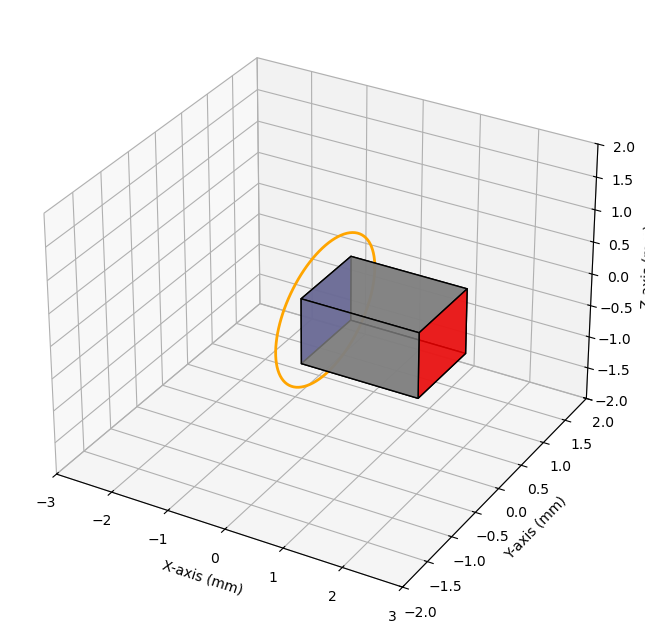

In [6]:
def plot_magnet_and_loop(ax, center):
    """Plots the magnet and vertical loop on the given 3D axis."""
    
    # Plot the rectangular magnet
    draw_rectangular_magnet(ax, center=center, size=(2, 1, 1))
    
    # Plot the wire loop
    plot_wire_loop(ax, radius=1)

def plot_wire_loop(ax, radius=1, num_points=100):
    """Plots a vertical circular wire loop centered at the origin in the YZ-plane."""
    
    # Parametric equations for a circle in the YZ-plane
    theta = np.linspace(0, 2 * np.pi, num_points)
    y = radius * np.cos(theta)  # Now varying along Y-axis
    z = radius * np.sin(theta)  # Now varying along Z-axis
    x = np.zeros_like(theta)  # The loop stays at x = 0 (YZ-plane)

    # Plot the wire loop
    ax.plot(x, y, z, color='orange', linewidth=2, label="Wire Loop")

def draw_rectangular_magnet(ax, center, size):
    """Draws a rectangular bar magnet centered at the given position."""
    
    cx, cy, cz = center
    dx, dy, dz = size
    
    # Shift so the magnet is centered along x-axis
    x_start = cx - dx / 2
    y_start = cy - dy / 2
    z_start = cz - dz / 2
    
    # Define the 8 corner points of the rectangle
    corners = np.array([
        [x_start, y_start, z_start], [x_start + dx, y_start, z_start], 
        [x_start + dx, y_start + dy, z_start], [x_start, y_start + dy, z_start],  # Bottom face
        [x_start, y_start, z_start + dz], [x_start + dx, y_start, z_start + dz], 
        [x_start + dx, y_start + dy, z_start + dz], [x_start, y_start + dy, z_start + dz]  # Top face
    ])
    
    # Define the 6 faces with their corner indices
    faces = [
        [corners[i] for i in [0, 1, 2, 3]],  # Bottom
        [corners[i] for i in [4, 5, 6, 7]],  # Top
        [corners[i] for i in [0, 1, 5, 4]],  # Side 1
        [corners[i] for i in [2, 3, 7, 6]],  # Side 2
        [corners[i] for i in [1, 2, 6, 5]],  # North pole (Red)
        [corners[i] for i in [0, 3, 7, 4]]   # South pole (Blue)
    ]
    
    # Assign colors (gray for body, red/blue for poles)
    face_colors = ['gray', 'gray', 'gray', 'gray', 'red', 'blue']
    
    # Create the 3D polygon collection
    poly3d = Poly3DCollection(faces, alpha=0.8, linewidths=1, edgecolors='k')
    poly3d.set_facecolor(face_colors)
    
    ax.add_collection3d(poly3d)


###############
# Setup figure
###############

# Create figure and axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Set axis limits
ax.set_xlim([-3, 3])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])

# Label Axes
ax.set_xlabel("X-axis (mm)")
ax.set_ylabel("Y-axis (mm)")
ax.set_zlabel("Z-axis (mm)")

# Plot the magnet and loop
plot_magnet_and_loop(ax, center=(1, 0, 0))

# Show the final combined plot
plt.show()

## Visualize B-Field
We'll consider a static B-field that "dipoles" around the magnetic moment. A static, or stationary magnetic field has no associated electric field with it. 

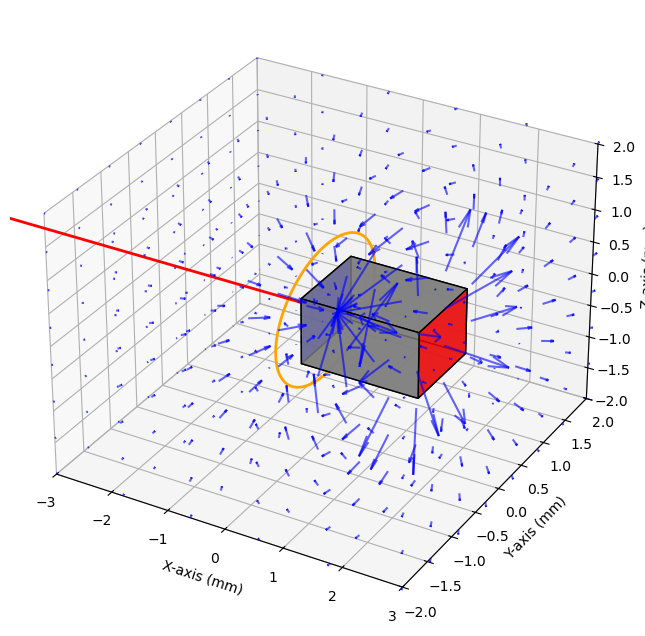

In [55]:
moment_strength = 10000


###############
# Setup figure
###############

# Create figure and axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Set axis limits
ax.set_xlim([-3, 3])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])

# Label Axes
ax.set_xlabel("X-axis (mm)")
ax.set_ylabel("Y-axis (mm)")
ax.set_zlabel("Z-axis (mm)")

# Plot the magnet and loop
plot_magnet_and_loop(ax, center=(1, 0, 0))

# Create and plot the magnetic field
field = MagneticField(moment_strength, dipole_center=(1, 0, 0))
field.plot_field(ax)  # Overlay the field on the same plot

# Show the final combined plot
plt.show()

## Induced Electric Field
As we move the magnet away from the origin, the changing magnetic field induces an electric field inside the loop. First we'll find the magnitude of the electric field, then we'll plot it. 

In [27]:
# Function to compute induced electric field over time
def compute_induced_E(magnet_start, magnet_end, loop_radius, moment_strength, dt):
    """Computes the induced electric field from Faraday's Law for a moving magnet."""
    
    # Magnetic field at two positions (before and after motion)
    field1 = MagneticField(moment_strength, magnet_start)
    field2 = MagneticField(moment_strength, magnet_end)
    
    # Compute flux at both times
    flux_t1 = field1.compute_flux(loop_radius)
    flux_t2 = field2.compute_flux(loop_radius)
    
    # Compute rate of change of flux
    dPhi_dt = (flux_t2 - flux_t1) / dt
    
    # Compute induced E-field using Faraday’s Law
    E_induced = - (1 / (2 * np.pi * loop_radius)) * dPhi_dt
    
    return E_induced


# Magnitude
magnet_start = (1, 0, 0)  # Initial dipole position
magnet_end = (2, 0, 0)    # Slightly moved dipole
loop_radius = 1.0
moment_strength = 10000
dt = 0.00001  # Small time step

# Compute induced electric field
E_induced = compute_induced_E(magnet_start, magnet_end, loop_radius, moment_strength, dt)
print(f"Induced Electric Field: {E_induced:.6f} V/m")

Induced Electric Field: 2.577844 V/m


## Plotting the Electric Field

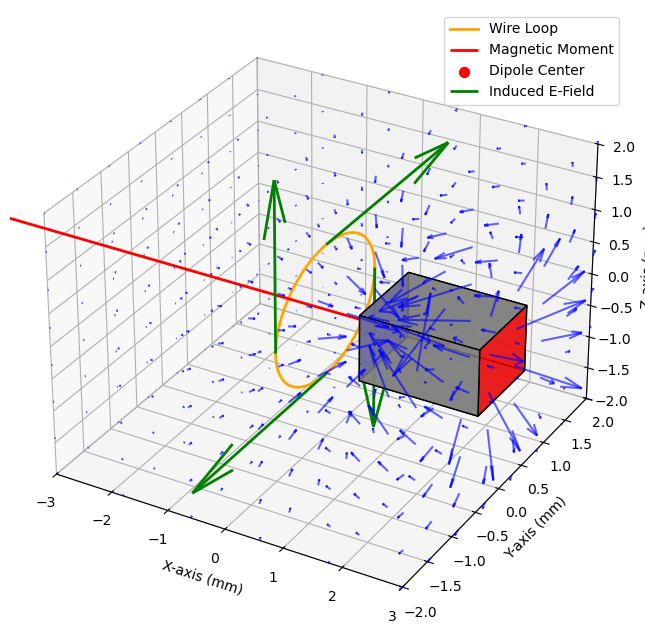

In [51]:
def plot_induced_electric_field(ax, radius, E_magnitude):
    """Plots four induced electric field vectors around the wire loop in the YZ-plane, following Lenz’s Law."""

    # Define four points on the loop (90° apart)
    theta_vals = [0, np.pi/2, np.pi, 3*np.pi/2]  # Angles in radians
    points = [(0, radius * np.cos(theta), radius * np.sin(theta)) for theta in theta_vals]

    # Compute tangential unit vectors
    E_vectors = [(0, np.sin(theta), -np.cos(theta)) for theta in theta_vals]  # Flipped direction

    # Scale vectors by E_magnitude for visualization
    E_vectors = [(x * E_magnitude, y * E_magnitude, z * E_magnitude) for x, y, z in E_vectors]

    # Plot the vectors
    for (px, py, pz), (Ex, Ey, Ez) in zip(points, E_vectors):
        ax.quiver(px, py, pz, Ex, Ey, Ez, color='green', linewidth=2, label="Induced E-Field" if px == 0 and py == radius else "")

    # Update legend
    ax.legend()


###############
# Setup figure
###############

# Create figure and axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Set axis limits
ax.set_xlim([-3, 3])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])

# Label Axes
ax.set_xlabel("X-axis (mm)")
ax.set_ylabel("Y-axis (mm)")
ax.set_zlabel("Z-axis (mm)")

# Plot the magnet and loop
plot_magnet_and_loop(ax, center=(2, 0, 0))

# Create and plot the magnetic field
field = MagneticField(moment_strength, dipole_center=(2, 0, 0))
field.plot_field(ax)  # Overlay the field on the same plot

# Plot Electric Field @ 4 points
plot_induced_electric_field(ax, loop_radius, E_magnitude=E_induced)

# Show the final combined plot
plt.show()

## Voltage
The changing magnetic field has produced an electric field, which also means that there's a voltage present. Let's go ahead and model that; the math should be easy, but the visualizing is a bit more complicated.

Induced EMF: 16.197074 V


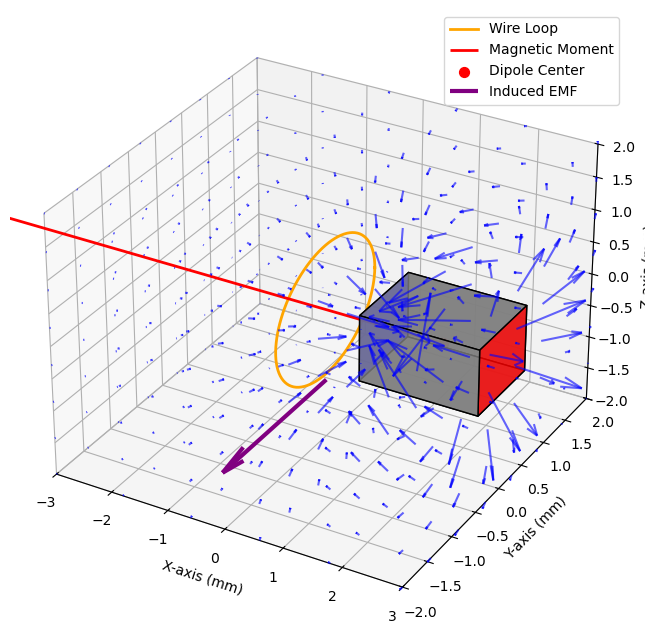

In [52]:
emf = E_induced * (2 * np.pi * loop_radius)
print(f"Induced EMF: {emf:.6f} V")

def plot_induced_emf(ax, radius, emf_magnitude, clockwise=False):
    """Plots a single vector representing the induced emf around the wire loop."""
    
    # Choose a point to place the vector (we'll use the bottom of the loop)
    emf_origin = (0, 0, -radius * 1.1)  # Slightly below the loop along Z

    # Tangential direction for the emf (aligned with induced current)
    if clockwise:
        emf_direction = (0, -1, 0)  # Downward along Y (Clockwise Current)
    else:
        emf_direction = (0, 1, 0)   # Upward along Y (Counterclockwise Current)

    # Scale the vector by emf magnitude
    emf_vector = tuple(emf_magnitude * np.array(emf_direction))

    # Plot the emf vector
    ax.quiver(*emf_origin, *emf_vector, color='purple', linewidth=3, arrow_length_ratio=0.2, label="Induced EMF")

    # Update legend
    ax.legend()


###############
# Setup figure
###############

# Create figure and axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Set axis limits
ax.set_xlim([-3, 3])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])

# Label Axes
ax.set_xlabel("X-axis (mm)")
ax.set_ylabel("Y-axis (mm)")
ax.set_zlabel("Z-axis (mm)")

# Plot the magnet and loop
plot_magnet_and_loop(ax, center=(2, 0, 0))

# Create and plot the magnetic field
field = MagneticField(moment_strength, dipole_center=(2, 0, 0))
field.plot_field(ax)  # Overlay the field on the same plot

# Plot EMF (Voltage)
plot_induced_emf(ax, loop_radius, emf_magnitude=emf/8, clockwise=True)

# Show the final combined plot
plt.show()